In [77]:
import sys, codecs, re, pdb, time, datetime, math, pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns;

from tqdm import tqdm
from scipy.sparse import csr_matrix
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import inv

#Loading data and initializing the matrices A and b as mentioned in the algorithm write-up
def data_initialize(dataset):
    data = pd.read_csv(dataset, sep="\s+", header=None)

    A = {}
    b = {}
    rewards = 0.0
    times = 0.0
    C = []

    for i in range(10):
        A[i] = np.identity(100)
        b[i] = np.zeros((100, 1))
    
    x_all = data.iloc[:, 2:]
    a_all = data.iloc[:, 0]
    r_all = data.iloc[:, 1]

    return data, A, b, rewards, times, C, x_all, a_all, r_all

#Select alpha values based on indices passed from linUCB() function
def generate_alpha(indexVal, alpha_option):
    alpha = 1.0
    if(alpha_option == 1):
        alpha = 0.09 / math.sqrt(indexVal + 1)
    elif(alpha_option == 2):
        alpha = 0.0085 / math.pow(indexVal + 1, 0.25)
    elif(alpha_option == 3):
        alpha = 10.6088 / (math.sqrt(indexVal + 1) + 2 * indexVal)
    
    '''
    All tried parameters in the grid-search
    
    alpha = 1.0 / math.sqrt(indexVal + 1) #979.0 1035.0 0.9458936284160746
    #alpha = 0.1 / math.sqrt(indexVal + 1) #979.0 1035.0 0.9458936284160746
    #alpha = 0.09 / math.sqrt(indexVal + 1) #977.0 1031.0 0.9476235744303032
    #alpha = 0.08 / math.sqrt(indexVal + 1) #971.0 1027.0 0.9454721572081639
    #alpha = 0.085 / math.sqrt(indexVal + 1) #971.0 1025.0 0.9473169807495628
    #alpha = 0.095 / math.sqrt(indexVal + 1) #977.0 1031.0 0.9476235744303032
    #alpha = 10.088 / math.sqrt(indexVal + 1) #615.0 1022.0 0.601761193565441
    #alpha = 8.088 / (indexVal + 1) #9982.0 1050.0 0.9352380061678089
    #alpha = 0.5088 / (indexVal + 1) #931.0 1021.0 0.9118510370371169
    #alpha = 5.5088 / (indexVal + 1) #972.0 1038.0 0.9364160947576017
    #alpha = 3.6088 / (indexVal + 1) #966.0 1031.0 0.9369543223128689
    #alpha = 50.6088 / (indexVal + 1) #943.0 1036.0 0.9102315723714699
    #alpha = 50.6088 / (2 * indexVal + 1) #949.0 1034.0 0.9177948822248664
    #alpha = 25.6088 / (math.sqrt(indexVal + 1) + 2 * indexVal) #961.0 1033.0 0.9303000067473373
    #alpha = 10.6088 / (math.sqrt(indexVal + 1) + 2 * indexVal) #974.0 1039.0 0.9374397557805818
    #alpha = 18.6088 / (math.sqrt(indexVal + 1) + math.pow(indexVal + 1, 3)) #947.0 1027.0 0.9221031234563658
    #alpha = 0.085 / math.pow(indexVal + 1, 0.25) #960.0 1034.0 0.928433179068358
    #alpha = 0.0085 / math.pow(indexVal + 1, 0.25) #979.0 1034.0 0.9468084190707525
    #alpha = 0.0085 / math.pow(indexVal + 1, 0.125) #971.0 1025.0 0.9473169807495628
    #alpha = 0.0085 / math.pow(indexVal + 1, 0.2975) #979.0 1036.0 0.944980603766351
    #alpha = 0.0085 / math.pow(indexVal + 1, 0.2999) #970.0 1031.0 0.9408340503555722
    '''

    return alpha

#Parameters: passed dataset, and options of alpha to iterate over
def linUCB(dataset, alpha_options):
    plt_vals = []

    for strategy, alpha_option in enumerate(alpha_options):
        data, A, b, rewards, times, C, x_all, a_all, r_all = data_initialize(dataset)
        for indexVal in tqdm(range(data.shape[0])):
            alpha = generate_alpha(indexVal, alpha_option)

            p = {}
            max_p = 0

            #Extract the context, award and reward at current timestamp
            x = x_all.iloc[indexVal,:].as_matrix(columns=None).reshape(x_all.shape[1], 1)
            a_t = a_all.iat[indexVal]
            r_t = r_all.iat[indexVal]

            #Evaluate probability for each action in the space
            for a in range(10):
                invA = inv(A[a])
                p[a] = ((invA.dot(b[a]).T).dot(x) + alpha * math.sqrt((x.T).dot(invA.dot(x))))[0]

                if(p[a] > p[max_p]):
                    max_p = a

            if(max_p + 1 == a_t):
                rewards = rewards + r_t
                times = times + 1

                A[max_p] = A[max_p] + x.dot(x.T)
                b[max_p] = b[max_p] + r_t * x

            C_t = rewards / (times + 0.0001)

            #For 2nd and greater iteration, add the indexVal
            if(indexVal > 0):
                C.append(C_t)

        #Append into list to be returned
        plt_vals.append([C, strategy, rewards, times, C_t])
    
    return plt_vals

#Calling the linUCB algorithms for the three set of alpha parameters (selected from generate_alpha() function)
plt_vals = linUCB('dataset.txt', [1, 2, 3])

100%|██████████| 10000/10000 [00:40<00:00, 246.54it/s]


94.672% a = 0.090 / sqrt(t) 	-> Rewards: 977.0 ,	Matches: 1031.0 ;	C(t): 0.9476235744303032
94.680% a = 0.0085 / pow(t, 0.25) 	-> Rewards: 979.0 ,	Matches: 1034.0 ;	C(t): 0.9468084190707525
93.743% a = 10.6088 / (sqrt(t) + 2t) 	-> Rewards: 974.0 ,	Matches: 1039.0 ;	C(t): 0.9374397557805818


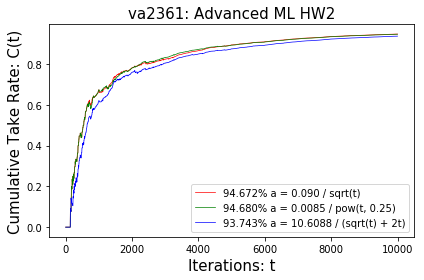

In [87]:
plt_graph = []
strategies = {}

strategies[0] = "94.672% a = 0.090 / sqrt(t)"
strategies[1] = "94.680% a = 0.0085 / pow(t, 0.25)"
strategies[2] = "93.743% a = 10.6088 / (sqrt(t) + 2t)"


for [C, strategy, rewards, times, C_t] in plt_vals:
    print(strategies[strategy], "\t-> Rewards:", rewards, ",\tMatches:", times, ";\tC(t):", C_t)
    plt_graph.append(C)
p1, = plt.plot(range(1, len(plt_graph[0])+1), plt_graph[0], 'r', label=strategies[0], linewidth=0.7, markersize=1)
p2, = plt.plot(range(1, len(plt_graph[1])+1), plt_graph[1], 'g', label=strategies[1], linewidth=0.7, markersize=1)
p3, = plt.plot(range(1, len(plt_graph[2])+1), plt_graph[2], 'b', label=strategies[2], linewidth=0.7, markersize=1)

plt.legend(handles=[p1, p2, p3])

plt.xlabel("Iterations: t", fontsize=15)
plt.ylabel("Cumulative Take Rate: C(t)", fontsize=15)
plt.title("va2361: Advanced ML HW2", fontsize=15)
plt.tight_layout()
#plt.plot(C)
#plt.show()
plt.savefig("va2361_HW2.png", dpi=400)